In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
from sklearn.cluster import KMeans
import random as rng

In [3]:
def preprocess(img):
#   img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  img = cv2.GaussianBlur(img, (9, 9), 0)
  img = img/255

  return img

In [4]:
def plotImage(img):
  plt.imshow(img)
  plt.show()

In [5]:
# empirical crop 10% of original image to get foot
def cropOrig(oimg):
  # x (Horizontal), y (Vertical Downwards) are start coordinates
  x1, y1, w1, h1 = 0, 0, oimg.shape[1], oimg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  crop = oimg[y1+y2:h1-y2,x1+x2:w1-x2]

  return crop

In [6]:
# display the crop foot in the original paper image
def overlayImage(crop, oimg):
  x1, y1, w1, h1 = 0, 0, oimg.shape[1], oimg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)
  new_image = np.zeros((oimg.shape[0], oimg.shape[1]), np.uint8)
  new_image[:, 0:oimg.shape[1]] = 100 # (B, G, R)

  new_image[ y1+y2:y1+y2+crop.shape[0], x1+x2:x1+x2+crop.shape[1]] = crop
  return new_image

In [7]:
def kMeans_cluster(img):
  # For clustering the image using k-means, we first need to convert it into a 2-dimensionary array
  # (H*W, N) N is the channel = 3
  image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

  # tweak the cluster size and see what happens to the output
  kmeans = KMeans(n_clusters = 2, random_state = 0).fit(image_2D)
  clustOut = kmeans.cluster_centers_[kmeans.labels_]

  # Reshape back the image from 2D to 3D image
  clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

  clusteredImg = np.uint8(clustered_3D*255)
  return clusteredImg

In [8]:
def getBoundingBox(img):
  contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  c = max(contours, key=cv2.contourArea) # filter the largest contours

  contours_poly = cv2.approxPolyDP(c, 3, True)
  boundRect = cv2.boundingRect(contours_poly)

  # print('contours poly: ', contours_poly)
  # print('bounding rectangle: ', boundRect)
  drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   

  paperbb = boundRect

  color = (0, 255, 0)
  cv2.drawContours(drawing, [contours_poly], 0, color)
  cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
            (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
  return drawing, boundRect


In [9]:
def extractPaper(img):
  print('img shape:', img.shape)
  contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  c = max(contours, key=cv2.contourArea)
  
  # print('found contours', contours)
  # contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
  # print('sorted contours: ', contours)
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.intp(box)
  # box = np.array(box, dtype='int')

    # get width and height of the detected rectangle
  width = int(rect[1][0])
  height = int(rect[1][1])

  src_pts = box.astype("float32")
  # coordinate of the points in box points after the rectangle has been
  # straightened
  dst_pts = np.array([[0, height-1],
                      [0, 0],
                      [width-1, 0],
                      [width-1, height-1]], dtype="float32")

  # the perspective transformation matrix
  M = cv2.getPerspectiveTransform(src_pts, dst_pts)

  # directly warp the rotated rectangle to get the straightened rectangle
  warped = cv2.warpPerspective(img, M, (width, height))
  print('warped shape: ', warped.shape)
  # plt.imshow(warped)
  # plt.show()
  return warped


In [10]:
def drawCnt(bRect, contours, img):
  print('bounding rectangle: ', bRect)
  drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
  color = (255, 255, 255)
  cv2.drawContours(drawing, [contours], 0, color, 2)
  cv2.rectangle(drawing, tuple(bRect[0]), tuple(bRect[2]), (255, 0, 0), 2)
  # cv2.drawContours(drawing, [bRect], 0, (255, 0, 0), 2)

  return drawing

In [11]:
def edgeDetection(clusteredImage):
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations = 1)
  edged = cv2.erode(edged, None, iterations = 1)
  return edged

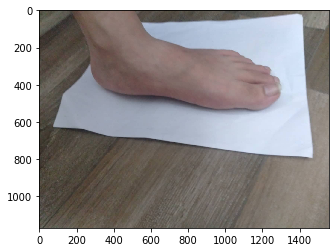

In [12]:
oimg = imread('foots_all/images/23796.jpeg')
plotImage(oimg)

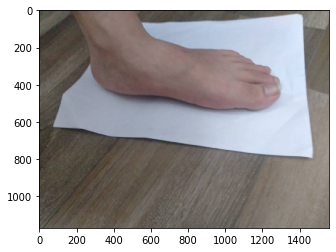

In [13]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg)

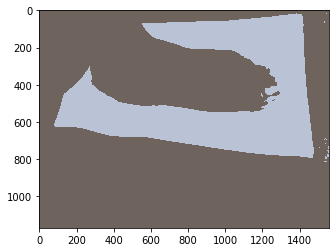

In [14]:
clusteredImg = kMeans_cluster(preprocessedOimg)
plotImage(clusteredImg)

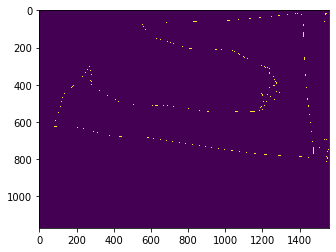

In [15]:
edgedImg = edgeDetection(clusteredImg)
plotImage(edgedImg)

img shape: (1170, 1560)
warped shape:  (769, 1404)


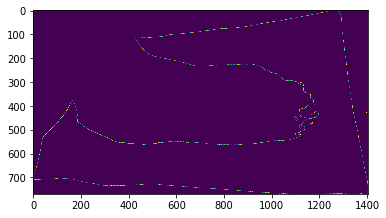

In [16]:

warped = extractPaper(edgedImg)

plotImage(warped)

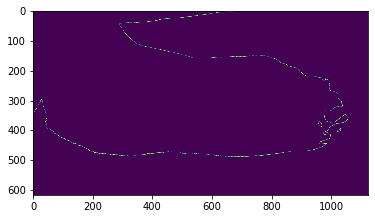

In [18]:

crop = cropOrig(warped)
plotImage(crop)

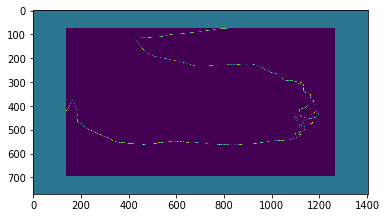

In [19]:

overlay = overlayImage(crop, warped)
plotImage(overlay)


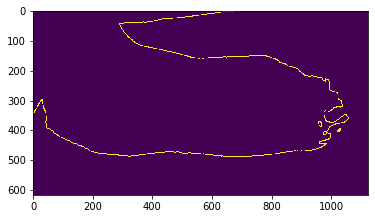

In [20]:
fedged = edgeDetection(crop)
plotImage(fedged)


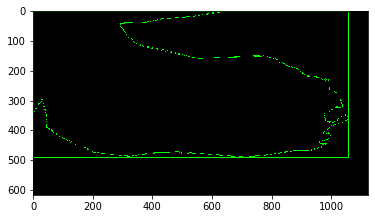

In [21]:
draw, boundRect = getBoundingBox(fedged)

plotImage(draw)

In [22]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)
  x2 = int(w1/10)
  fh = y2 + fboundRect[3]
  fw = x2 + fboundRect[2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  print("Feet height: ", fh)
  print("Feet Width: ", fw)

  print("Paper height: ", ph)
  print("Paper width: ", pw)
  
  opw = 210
  oph = 297

  ofs_w = 0
  ofs_h = 0
  if fw > fh:
    ofs_h = (oph/pw)*fw
    ofs_w = (opw/pw)*ph
  else:
    ofs_h = (oph/ph)*fh
    ofs_w = (opw/pw)*fw


  return ofs_h/10, ofs_w/10

In [23]:
print("feet size (cm): ", calcFeetSize(warped, boundRect))

Feet height:  566
Feet Width:  1199
Paper height:  769
Paper width:  1404
feet size (cm):  (25.36346153846154, 11.502136752136753)


# **Streamlit**

In [24]:
pip install streamlit

  Using cached streamlit-1.10.0-py2.py3-none-any.whl (9.1 MB)
  Using cached GitPython-3.1.27-py3-none-any.whl (181 kB)
  Using cached pydeck-0.7.1-py2.py3-none-any.whl (4.3 MB)
  Using cached validators-0.20.0.tar.gz (30 kB)
  Using cached altair-4.2.0-py3-none-any.whl (812 kB)
  Using cached blinker-1.4.tar.gz (111 kB)
  Using cached rich-12.4.4-py3-none-any.whl (232 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached Pympler-1.0.1-py3-none-any.whl (164 kB)
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
  Using cached Pygments-2.12.0-py3-none-any.whl (1.1 MB)
  Using cached tzdata-2022.1-py2.py3-none-any.whl (339 kB)
  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Created wheel for validators: filename=val

ERROR: spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: rich 12.4.4 has requirement typing-extensions<5.0,>=4.0.0; python_version < "3.9", but you'll have typing-extensions 3.10.0.2 which is incompatible.
ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "C:\Users\nguye\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 404, in run
    use_user_site=options.use_user_site,
  File "C:\Users\nguye\anaconda3\lib\site-packages\pip\_internal\req\__init__.py", line 71, in install_given_reqs
    **kwargs
  File "C:\Users\nguye\anaconda3\lib\site-packages\pip\_internal\req\req_install.py", line 815, in install
    warn_script_location=warn_script_location,
  File "C:\Users\nguye\anaconda3\lib\s

In [26]:
streamlit run main.py

SyntaxError: invalid syntax (<ipython-input-26-2e02c77d4725>, line 1)